In [70]:
#Import the library
import sqlite3 as sqlite
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [71]:
#Setting connection to Olist Database
con = sqlite.connect('C:\\Users\\rifap\\Downloads\\olist.db')

In [72]:
#Show the list of table from Olist Database
query = """
SELECT * FROM sqlite_master WHERE type='table';
"""
data = pd.read_sql(query,con)
data

,type,name,tbl_name,rootpage,sql
0,table,olist_order_customer_dataset,olist_order_customer_dataset,2,"CREATE TABLE ""olist_order_customer_dataset"" (\..."
1,table,olist_order_dataset,olist_order_dataset,2644,"CREATE TABLE ""olist_order_dataset"" (\n""index"" ..."
2,table,olist_order_reviews_dataset,olist_order_reviews_dataset,7660,"CREATE TABLE ""olist_order_reviews_dataset"" (\n..."
3,table,olist_order_payments_dataset,olist_order_payments_dataset,11735,"CREATE TABLE ""olist_order_payments_dataset"" (\..."
4,table,olist_order_items_dataset,olist_order_items_dataset,13754,"CREATE TABLE ""olist_order_items_dataset"" (\n""i..."
5,table,olist_products_dataset,olist_products_dataset,18289,"CREATE TABLE ""olist_products_dataset"" (\n""inde..."
6,table,olist_sellers_dataset,olist_sellers_dataset,18983,"CREATE TABLE ""olist_sellers_dataset"" (\n""index..."
7,table,olist_geolocation_dataset,olist_geolocation_dataset,19040,"CREATE TABLE ""olist_geolocation_dataset"" (\n""i..."
8,table,product_category_name_translation,product_category_name_translation,33966,"CREATE TABLE ""product_category_name_translatio..."


# Objective

In this data analysis, my primary objectives are categorized into four groups:
<br>

A.Monthly and Annual Data
 - How’s the MoM order growth? Which month Olist had highest order?
- How’s the MoM revenue growth? Which month Olist had highest revenue?
- How's the YoY customer growth?
<br>

B. Product Performance
- What are the top 10 products based on order volume?
<br>

C. Transaction Analysis
- How's the distribution of each payment method?
- Which transaction time has the highest payment?
<br>

D. Regional Performance
- What are the top 5 city with the highest number of orders?




# Data Cleansing

The initial group analysis is focus on order and revenue monthly data. The table that will be used are olist_order_dataset and olist_order_payments_dataset.

### Data Cleansing for olist_order_dataset Table

In [73]:
#Understand the data from olist_order_dataset 
query = """
SELECT * FROM olist_order_dataset;
"""
order = pd.read_sql(query,con)
order.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          99441 non-null  int64 
 1   order_id                       99441 non-null  object
 2   customer_id                    99441 non-null  object
 3   order_status                   99441 non-null  object
 4   order_purchase_timestamp       99441 non-null  object
 5   order_approved_at              99281 non-null  object
 6   order_delivered_carrier_date   97658 non-null  object
 7   order_delivered_customer_date  96476 non-null  object
 8   order_estimated_delivery_date  99441 non-null  object
dtypes: int64(1), object(8)
memory usage: 6.8+ MB


#### Identify missing value and duplicate

In [74]:
#Identify missing value from olist_order_dataset
order_nan = order.isna().sum()
print(order_nan)

#Identify duplicate from olist_order_dataset
order[order.duplicated(keep=False)]

index                               0
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


The order table contains three fields with missing values: order_approved_at, order_delivered_carrier_date, and order_delivered_customer_date. 
The column with missing values has object data type, thus during the cleaning stage, we will convert the datetime data format and fill in the missing value with the median value.

In [75]:
#Convert data in columns with the same format
order['order_purchase_timestamp'] = pd.to_datetime(order['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
order['order_approved_at'] = pd.to_datetime(order['order_approved_at'], format='%Y-%m-%d %H:%M:%S')
order['order_delivered_carrier_date'] = pd.to_datetime(order['order_delivered_carrier_date'], format='%Y-%m-%d %H:%M:%S')
order['order_delivered_customer_date'] = pd.to_datetime(order['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
order['order_estimated_delivery_date'] = pd.to_datetime(order['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')

#Impute missing value with median data
median_approved_at = order['order_approved_at'].median()
order['order_approved_at'].fillna(median_approved_at, inplace = True)

median_delivered_carried_date = order['order_delivered_carrier_date'].median()
order['order_delivered_carrier_date'].fillna(median_delivered_carried_date, inplace = True)

median_delivered_customer_date = order['order_delivered_customer_date'].median()
order['order_delivered_customer_date'].fillna(median_delivered_carried_date, inplace = True)

#Reidentify if there's null
order_clean_checked = order.isna().sum()
print(order_clean_checked)
order_clean = order
order.head()

index                            0
order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64


,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


Order table don't have numeric types data, hence we don't need to identify the outlier.

### Data Cleansing for olist_order_payment_dataset

In [76]:
#Understand the data from olist_order_payments_dataset
query = """
SELECT * FROM olist_order_payments_dataset;
"""
payment = pd.read_sql(query,con)
payment.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   index                 103886 non-null  int64  
 1   order_id              103886 non-null  object 
 2   payment_sequential    103886 non-null  int64  
 3   payment_type          103886 non-null  object 
 4   payment_installments  103886 non-null  int64  
 5   payment_value         103886 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 4.8+ MB


#### Identify missing value and duplicate

In [77]:
#Identify missing value from olist_order_payments_dataset
payment_nan = payment.isna().sum()
print(payment_nan)

#Identify duplicate from olist_order_payments_dataset
payment[payment.duplicated(keep=False)]

index                   0
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64


,index,order_id,payment_sequential,payment_type,payment_installments,payment_value


#### Identify and handle outlier

index                     int64
order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object


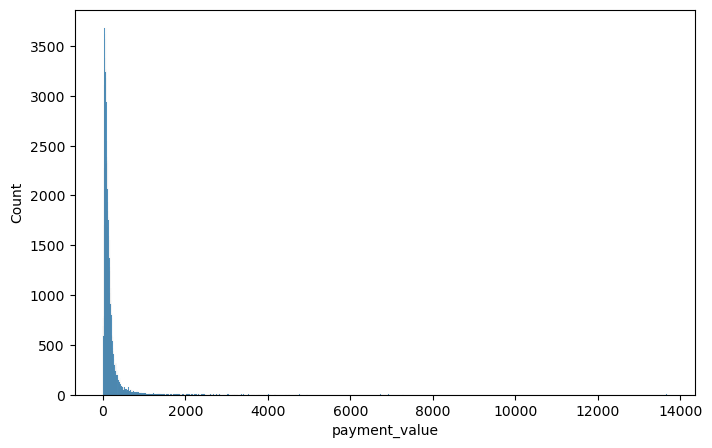

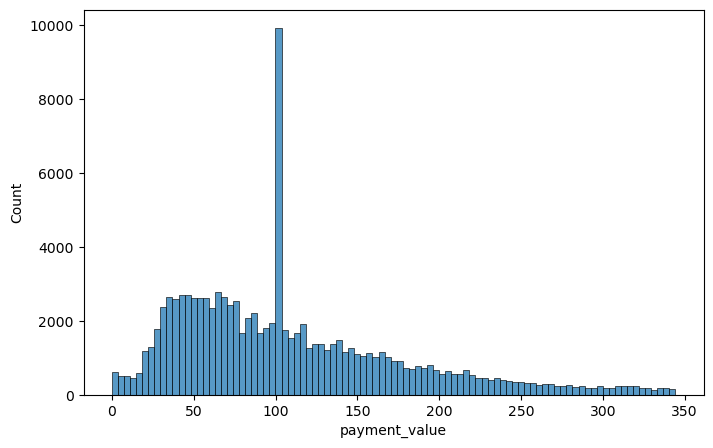

In [78]:
#Check the data type before identify outlier
payment_types = payment.dtypes
print(payment_types)

#Identify outlier from payment_value column
fig, ax = plt.subplots(figsize= (8,5))
sns.histplot(data=payment, x='payment_value')

#Calculate the IQR for payment_value column
Q1 = payment['payment_value'].quantile(0.25)
Q3 = payment['payment_value'].quantile(0.75)
IQR = Q3 - Q1

#Define lower and upper bounds from payment_value column
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Identify outliers
outliers = payment[(payment['payment_value'] < lower_bound) | (payment['payment_value'] > upper_bound)]

#Calculate median to replace the outlier
median_payment_value = payment['payment_value'].median()     

#Impute outliers with the median
payment_wo_outlier = payment
payment_wo_outlier.loc[(payment_wo_outlier['payment_value'] < lower_bound) | (payment_wo_outlier['payment_value'] > upper_bound), 'payment_value'] = median_payment_value

#Show the data distribution after handling the outlier
fig, ax = plt.subplots(figsize= (8,5))

sns.histplot(data=payment_wo_outlier, x='payment_value')

payment_clean = payment_wo_outlier

There's no missing values and duplicate in olist_order_payments_dataset. We also already replace the outlier data with median data. So, we can move to explore data from olist_products_dataset and olist_order_items_dataset tables

### Data Cleansing for olist_products_dataset

In [79]:
#Understand the data from olist_products_dataset 
query = """
SELECT * FROM olist_products_dataset;
"""
product = pd.read_sql(query,con)
product.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       32951 non-null  int64  
 1   product_id                  32951 non-null  object 
 2   product_category_name       32341 non-null  object 
 3   product_name_lenght         32341 non-null  float64
 4   product_description_lenght  32341 non-null  float64
 5   product_photos_qty          32341 non-null  float64
 6   product_weight_g            32949 non-null  float64
 7   product_length_cm           32949 non-null  float64
 8   product_height_cm           32949 non-null  float64
 9   product_width_cm            32949 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.5+ MB


### Identify missing value and duplicate

In [80]:
#Identify missing value from olist_products_dataset 
product_nan = product.isna().sum()
print(product_nan)

#Identify duplicate from olist_products_dataset
product[product.duplicated(keep=False)]

index                           0
product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


,index,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


There are several missing values in olist_products_dataset column, including product_category_name, product_name_length, product_description_length, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, and product_width_cm.
<br>
As there are many columns with missing values, we will replace empty values with "unknown" to keep the number of rows of data analyzed from decreasing significantly. To maintain the data distribution, columns with numeric data will be replaced with the median data from that column.

In [81]:
#Impute missing value with "unknown"
product["product_category_name"].fillna("Unknown", inplace=True)

#Impute missing value with median data for numeric data column
median_name_lenght = product['product_name_lenght'].median()
product['product_name_lenght'].fillna(median_name_lenght, inplace = True)

median_description_lenght = product['product_description_lenght'].median()
product['product_description_lenght'].fillna(median_description_lenght, inplace = True)

median_photos_qty = product['product_photos_qty'].median()
product['product_photos_qty'].fillna(median_photos_qty, inplace = True)

median_weight_g = product['product_weight_g'].median()
product['product_weight_g'].fillna(median_weight_g, inplace = True)

median_length_cm = product['product_length_cm'].median()
product['product_length_cm'].fillna(median_length_cm, inplace = True)

median_height_cm = product['product_height_cm'].median()
product['product_height_cm'].fillna(median_height_cm, inplace = True)

median_width_cm = product['product_width_cm'].median()
product['product_width_cm'].fillna(median_width_cm, inplace = True)

#Reidentify if there's null
product_nan = product.isna().sum()
print(product_nan)

index                         0
product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64


### Data Cleansing for olist_order_items_dataset

In [82]:
#Understand the data from olist_order_items_dataset 
query = """
SELECT * FROM olist_order_items_dataset;
"""
order_items = pd.read_sql(query,con)
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                112650 non-null  int64  
 1   order_id             112650 non-null  object 
 2   order_item_id        112650 non-null  int64  
 3   product_id           112650 non-null  object 
 4   seller_id            112650 non-null  object 
 5   shipping_limit_date  112650 non-null  object 
 6   price                112650 non-null  float64
 7   freight_value        112650 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 6.9+ MB


#### Identify missing value and duplicate

In [83]:
#Identify missing value from olist_order_items_dataset 
order_items_nan = order_items.isna().sum()
print(order_items_nan)

#Identify duplicate from olist_order_items_dataset
order_items[order_items.duplicated(keep=False)]

index                  0
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64


,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


#### Identify and handle outlier

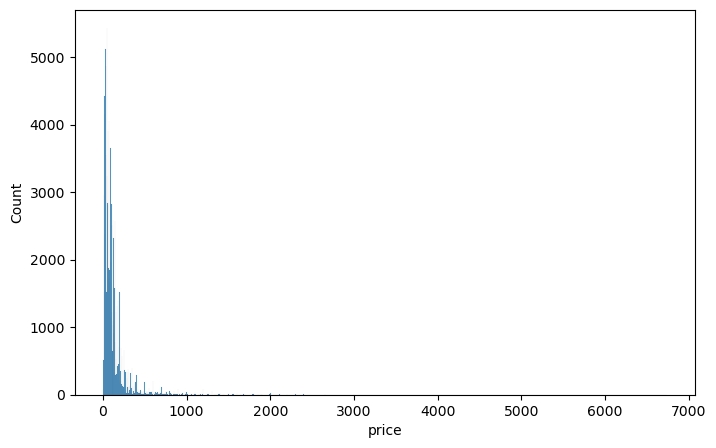

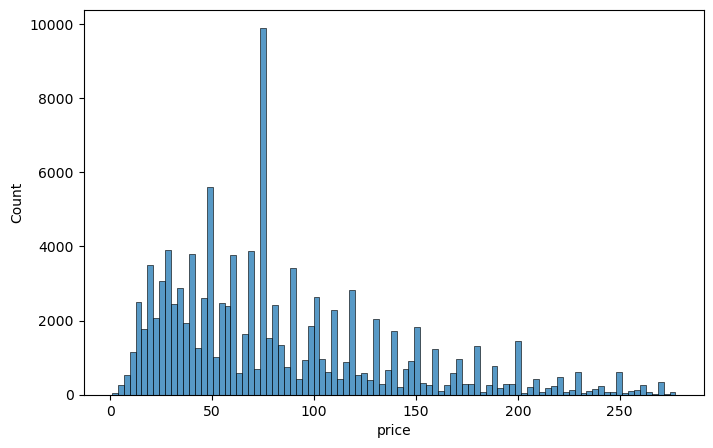

In [84]:
#Identify outlier from price column
fig, ax = plt.subplots(figsize= (8,5))
sns.histplot(data=order_items, x='price')

#Calculate the IQR for price column
Q1_price = order_items['price'].quantile(0.25)
Q3_price = order_items['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

#Define lower and upper bounds from payment_value column
lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

#Identify outliers
outliers_price = order_items[(order_items['price'] < lower_bound_price) | (order_items['price'] > upper_bound_price)]

#Calculate median to replace the outlier
median_price = order_items['price'].median()     

#Replace outliers with the median
order_items_wo_outlier = order_items
order_items_wo_outlier.loc[(order_items_wo_outlier['price'] < lower_bound_price) | (order_items_wo_outlier['price'] > upper_bound_price), 'price'] = median_price

#Show the data distribution after handling the outlier
fig, ax = plt.subplots(figsize= (8,5))
sns.histplot(data=order_items_wo_outlier, x='price')

order_items_clean = order_items_wo_outlier

There's no missing values or duplicate data in olist_order_items_dataset. We also already replace the outlier data with median data. So, we can move to explore data from olist_order_customer_dataset.

### Data Cleansing for olist_order_customer_dataset

In [85]:
#Understand the data from olist_order_customer_dataset
query = """
SELECT * FROM olist_order_customer_dataset;
"""
customer = pd.read_sql(query,con)
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     99441 non-null  int64 
 1   customer_id               99441 non-null  object
 2   customer_unique_id        99441 non-null  object
 3   customer_zip_code_prefix  99441 non-null  int64 
 4   customer_city             99441 non-null  object
 5   customer_state            99441 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB


#### Identify missing value and duplicate

In [86]:
#Identify missing value from olist_order_customer_dataset 
customer_nan = customer.isna().sum()
print(customer_nan)

#Identify duplicate from olist_order_customer_dataset
customer[customer.duplicated(keep=False)]

index                       0
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64


,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


There's no missing values or duplicate data in olist_order_items_dataset. So, we can move to analyze the data.

### Data Checking for product_category_name_translation

In [87]:
#Understand the data from product_category_name_translation	
query = """
SELECT * FROM product_category_name_translation;
"""
translation = pd.read_sql(query,con)
translation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   index                          71 non-null     int64 
 1   product_category_name          71 non-null     object
 2   product_category_name_english  71 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.8+ KB


## Data Analysis

### Monthly Data

#### 1. How’s the MoM order growth? Which month Olist had highest order?

['delivered' 'invoiced' 'shipped' 'processing' 'unavailable' 'canceled'
 'created' 'approved']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   index                          99441 non-null  int64         
 1   order_id                       99441 non-null  object        
 2   customer_id                    99441 non-null  object        
 3   order_status                   99441 non-null  object        
 4   order_purchase_timestamp       99441 non-null  datetime64[ns]
 5   order_approved_at              99441 non-null  datetime64[ns]
 6   order_delivered_carrier_date   99441 non-null  datetime64[ns]
 7   order_delivered_customer_date  99441 non-null  datetime64[ns]
 8   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), int64(1), object(3)
memory usage:

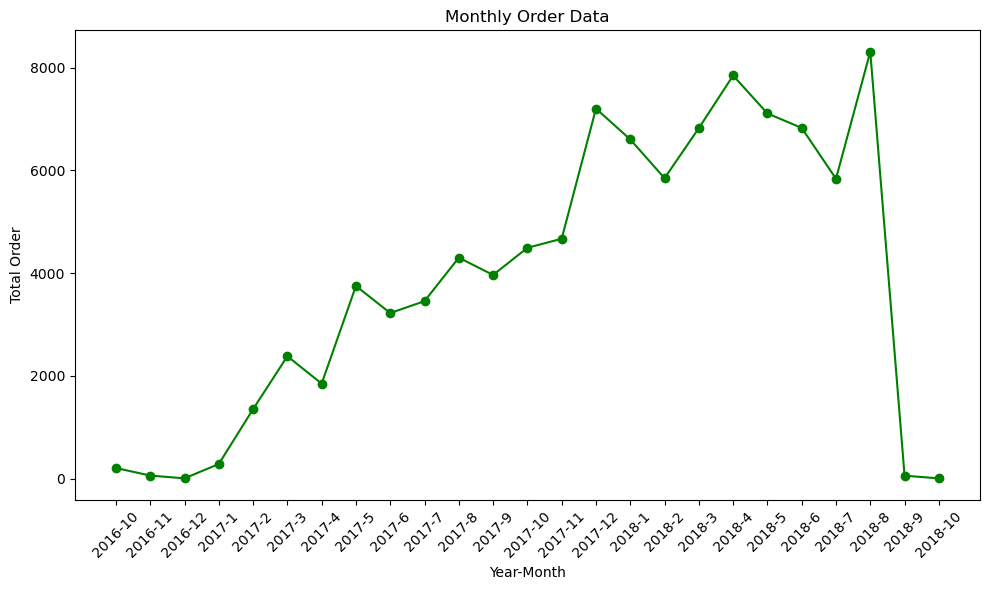

In [88]:
#Check order status value
order_status_unique = order['order_status'].unique()
print(order_status_unique)

#Check order_clean data type
order_clean.info()

#Extract year and month from delivered order in separate column
order_clean['year'] = order_clean['order_delivered_customer_date'].dt.year
order_clean['month'] = order_clean['order_delivered_customer_date'].dt.month

#Check DataFrame after extracting month and year data
order_clean.head()

#Filter DataFrame based on order_status: "delivered"
order_clean_filtered = order_clean[order_clean['order_status'] == 'delivered']
order_clean_filtered.head()

#Group by 'Year' and 'Month' and count the number of orders
monthly_order_counts = order_clean_filtered.groupby(['year', 'month'])['order_id'].count().reset_index()
print(monthly_order_counts)

#Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(
    monthly_order_counts['year'].astype(str) + '-' + monthly_order_counts['month'].astype(str),
    monthly_order_counts['order_id'],
    marker='o',  #Points for better visibility
    linestyle='-',
    color='green'
)

# Set labels and title 
plt.xlabel('Year-Month')
plt.ylabel('Total Order')
plt.title('Monthly Order Data')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


#### 2. How’s the MoM revenue growth? Which month Olist had highest revenue?

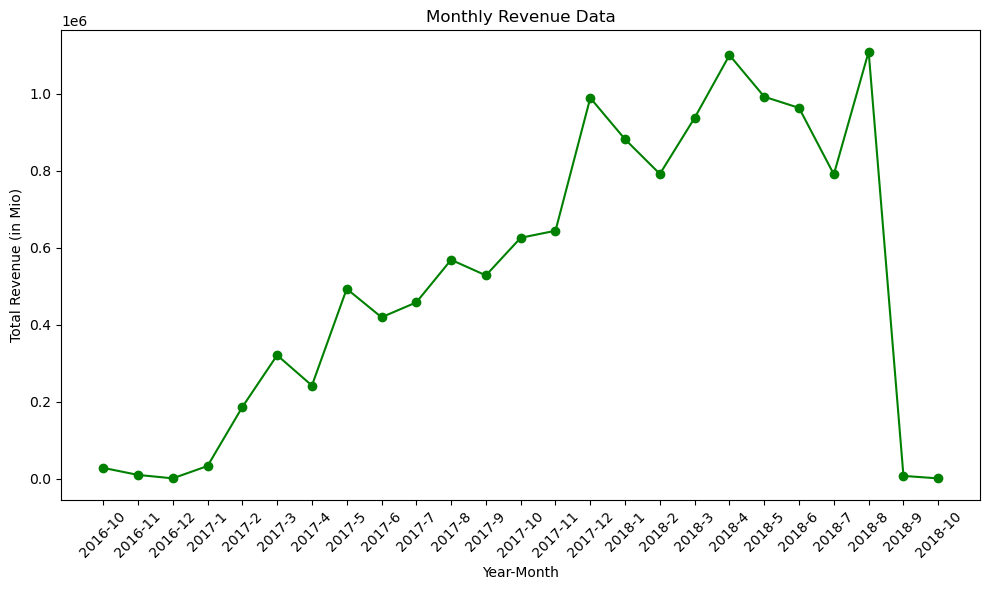

In [89]:
#Merge data from order, order_items, and payments table
merge_order_orderItems_payment = order_clean.merge(order_items_clean, on='order_id').merge(payment_clean, on='order_id')
merge_order_orderItems_payment.head()

#Filter DataFrame based on order_status: "delivered"
merge_order_orderItems_payment_filtered = merge_order_orderItems_payment[merge_order_orderItems_payment['order_status'] == 'delivered']
merge_order_orderItems_payment_filtered.head()

#Group by 'Year' and 'Month' and sum total revenue
monthly_revenue = merge_order_orderItems_payment_filtered.groupby(['year', 'month'])['payment_value'].sum().reset_index()

#Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(
    monthly_revenue['year'].astype(str) + '-' + monthly_revenue['month'].astype(str),
    monthly_revenue['payment_value'],
    marker='o',  #Points for better visibility
    linestyle='-',
    color='green'  
)

# Set labels and title 
plt.xlabel('Year-Month')
plt.ylabel('Total Revenue (in Mio)')
plt.title('Monthly Revenue Data')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

#### 3. How's the YoY customer growth?

   year  customer_id
0  2016          267
1  2017        40930
2  2018        55281


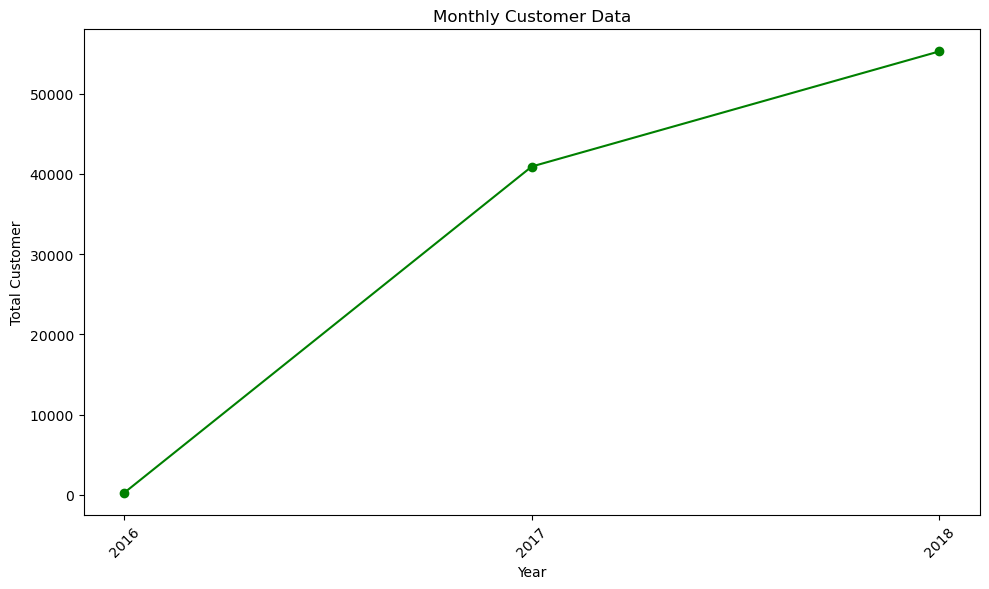

In [90]:
#Calculate total unique customer with delivered order each year
yearly_customer_counts = order_clean_filtered.groupby(['year'])['customer_id'].nunique().reset_index()
print(yearly_customer_counts)


#Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(
    yearly_customer_counts['year'].astype(str),
    yearly_customer_counts['customer_id'],
    marker='o',  #Points for better visibility
    linestyle='-',
    color='green'
)

# Set labels and title 
plt.xlabel('Year')
plt.ylabel('Total Customer')
plt.title('Yearly Customer Data')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

### Product Performance Data

#### 1. What are the top 10 products based on order volume?


C:\Users\rifap\AppData\Local\Temp\ipykernel_10900\1705177422.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_x'} in the result is deprecated and will raise a MergeError in a future version.
  merge_order_orderItems_product = order_clean.merge(order_items_clean, on='order_id').merge(product, on='product_id').merge(translation, on='product_category_name')


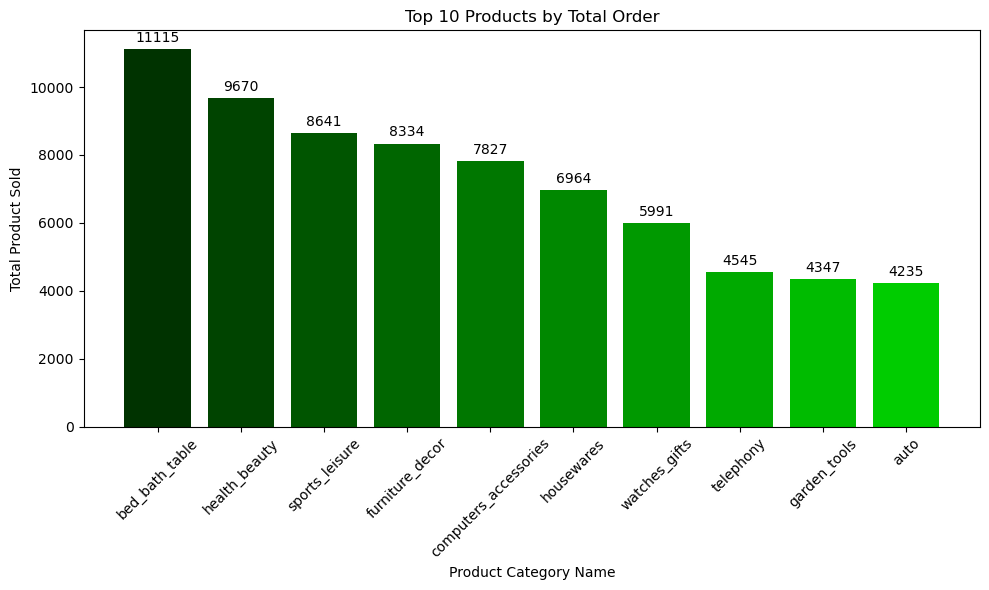

In [91]:
#Merge data from order, order_items, and payments table
merge_order_orderItems_product = order_clean.merge(order_items_clean, on='order_id').merge(product, on='product_id').merge(translation, on='product_category_name')
merge_order_orderItems_product.head()

#identify top 10 product data
top_10_highest_order = merge_order_orderItems_product.groupby('product_category_name_english').agg({'order_id': 'count'}).nlargest(10, 'order_id').reset_index()

#Rename column
top_10_highest_order = top_10_highest_order.rename(columns={'order_id': 'total_order'})
top_10_highest_order

#Visualize the data
custom_colors = ['#003300', '#004400', '#005500', '#006600', '#007700',
                         '#008800', '#009900', '#00AA00', '#00BB00', '#00CC00']
plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_highest_order['product_category_name_english'], top_10_highest_order['total_order'], color=custom_colors)
plt.xlabel('Product Category Name')
plt.ylabel('Total Product Sold')
plt.title('Top 10 Products by Total Order')
plt.xticks(rotation=45)
plt.tight_layout()

# Add data labels (values) on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()


### Transaction Analysis

#### 1. How's the distribution of each payment method?


['credit_card' 'boleto' 'voucher' 'debit_card' 'not_defined']
payment_type
boleto         19784
credit_card    76795
debit_card      1529
not_defined        3
voucher         5775
Name: order_id, dtype: int64


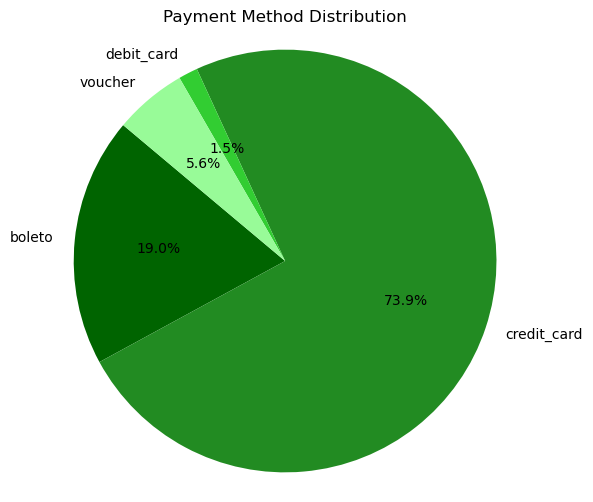

In [92]:
#Show all payment type
payment_clean__unique = payment_clean['payment_type'].unique()
print(payment_clean__unique)

#Calculate total transaction for each payment method
payment_counts = payment_clean.groupby('payment_type')['order_id'].count()
print(payment_counts)

#Exclude not_defined data
type_to_exclude = 'not_defined'

# Filter the DataFrame to exclude not_defined type
filtered_payment_counts = payment_counts[payment_counts.index != type_to_exclude]

# Create a pie chart
colors = ['#006400', '#228B22', '#32CD32', '#98FB98']
plt.figure(figsize=(6, 6))
label_distance = 2.05
plt.pie(filtered_payment_counts, labels=filtered_payment_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Payment Method Distribution')
plt.axis('equal')

# Show the pie chart
plt.show()

#### 2. Which time has the highest transaction?

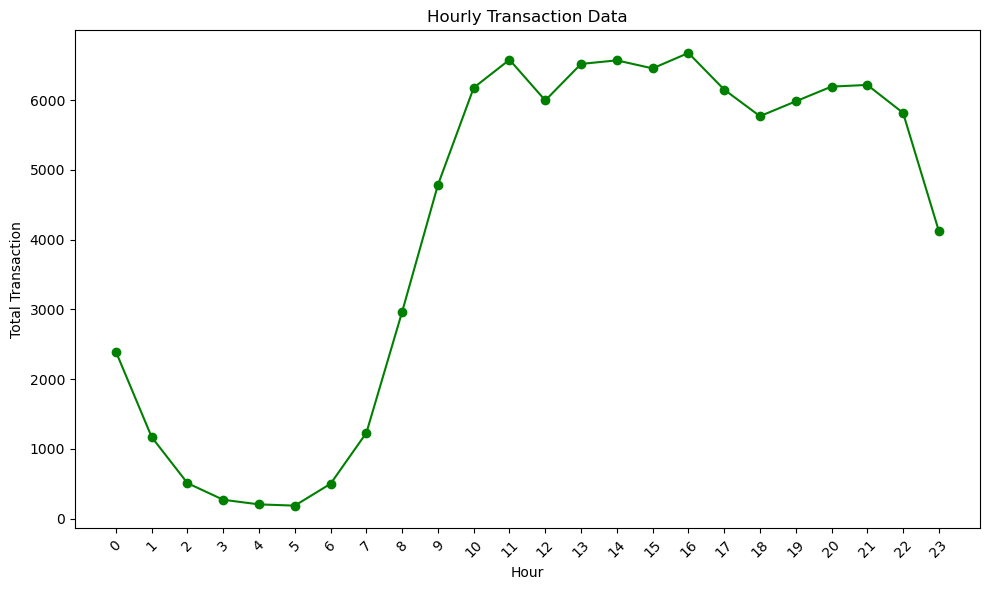

In [104]:
#Extract hour from purchase timestamp in separate column
order_clean['purchase_hour'] = order_clean['order_purchase_timestamp'].dt.hour

#Calculate total purchase in each hour
purchase_hour_counts = order_clean.groupby(['purchase_hour'])['order_purchase_timestamp'].count().reset_index()

#Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(
    purchase_hour_counts['purchase_hour'].astype(str),
    purchase_hour_counts['order_purchase_timestamp'],
    marker='o',  #Points for better visibility
    linestyle='-',
    color='green'
)

# Set labels and title 
plt.xlabel('Hour')
plt.ylabel('Total Transaction')
plt.title('Hourly Transaction Data')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


### Region Analysis

#### 1. What are the top 5 city with the highest number of orders?


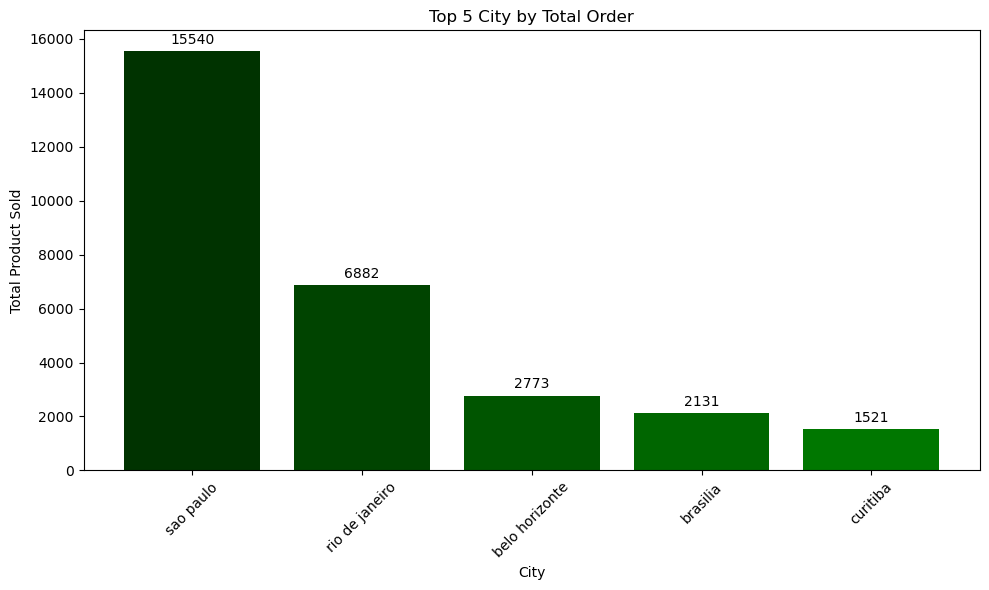

In [ ]:
#Merge data from order and customer table
merge_order_customer = pd.merge(customer, order_clean, on= 'customer_id')

#Identify top 5 city with highest orders
top_10_city_highest_order = merge_order_customer.groupby('customer_city').agg({'order_id': 'count'}).nlargest(5, 'order_id').reset_index()

#Rename column
top_10_city_highest_order = top_10_city_highest_order.rename(columns={'order_id': 'total_order'})
top_10_city_highest_order

#Visualize the data
custom_colors = ['#003300', '#004400', '#005500', '#006600', '#007700']
plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_city_highest_order['customer_city'], top_10_city_highest_order['total_order'], color=custom_colors)
plt.xlabel('City')
plt.ylabel('Total Product Sold')
plt.title('Top 5 City by Total Order')
plt.xticks(rotation=45)
plt.tight_layout()

# Add data labels (values) on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()